# Bayesian Time Series Analysis of Spotify Listening Time per Day

## Set up 

In [6]:
# general pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# model pkgs
import pymc as pm
import arviz as az
# assumption pkg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm


# Load the prepared data
spot = pd.read_csv('spot_day_data.csv')

spot = spot[['date', 'minutes_listened']]

spot['date'] = pd.to_datetime(spot['date'])  # Ensure 'date' column is datetime format
spot.set_index('date', inplace=True)  # Set 'date' column as index


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



## Model Specifications

Proceeding with a Bayesian autoregressive model of order 1, with a model equation of \( y_t \sim \text{Normal}(\phi \cdot y_{t-1} + e_t, \sigma^2) \).

### Parameters

This model consists of 3 parameters:

1. **Autoregressive Coefficient (\(\phi\))**: Represents the effect of the previous value \( y_{t-1} \) on \( y_t \).
2. **Error Term (\(e_t\))**: At time \( t \), assumed to be normally distributed with mean 0 and variance \( \sigma^2 \).
3. **Sigma (\(\sigma\))**: Represents the standard deviation of \( y_t \) (time spent listening to music in a day).

where:

- \( y_t \) is the time spent listening to music on day \( t \),
- \( y_{t-1} \) is the time spent listening on the previous day \( t-1 \),
- \( t \) denotes the day.

### Model Assumptions

1. **Stationarity**: The time series should exhibit the same mean, variance, and autocorrelation structure over time.
2. **White Noise**: The errors \( e_t \) have a mean of 0, equal variance, and are not autocorrelated.

This representation ensures clarity in describing the Bayesian AR(1) model and its underlying assumptions.



## Checking Assumptions

### Stationarity Check

In [7]:
# stationarity check
# Assuming your time series is in a variable named 'series'
result = adfuller(spot['minutes_listened'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -5.1113968709709345
p-value: 1.3297803599857623e-05
Critical Values:
1%: -3.4491725955218655
5%: -2.8698334971428574
10%: -2.5711883591836733


We meet the assumption of stationary, because we rejected (pval = 1.3e-05) the null hypothesis for the nonstationary test and the ADF stat is less the all the critical values

### White Noise Check

/home/arrowboy/Documents/School/Spring2024/Stat415/project/myenv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


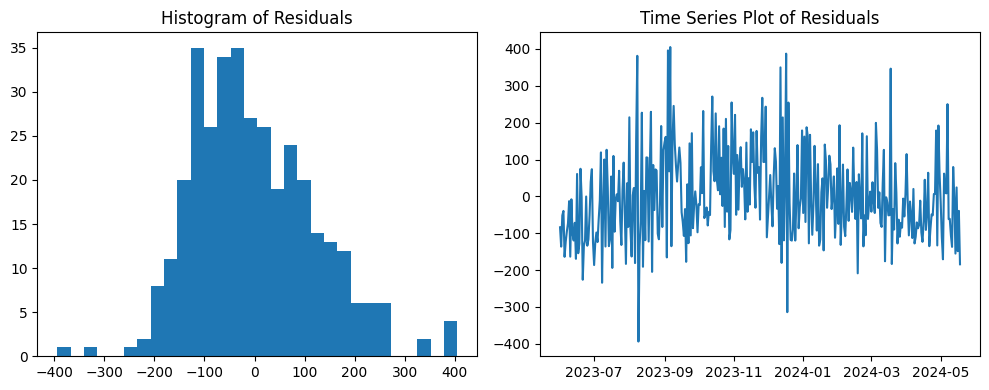

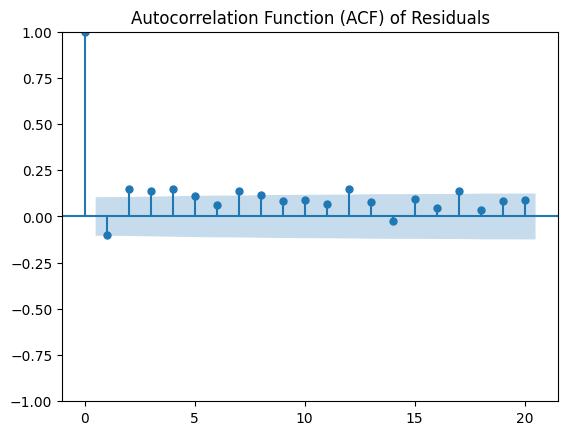

In [8]:
# Fit AR(1) model
# taking log of the data
model = AutoReg(spot['minutes_listened'], lags=1)
results = model.fit()

# Get residuals
residuals = results.resid


# Plot residuals
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.subplot(1, 2, 2)
plt.plot(residuals)
plt.title('Time Series Plot of Residuals')
plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()


The error residuals (white noise) assumptions are satisfied

- normality: appear to be approximetly normally distributed (there is a kinda heavy tail, but mostly normal)
- equal var: they seem to be pretty random and consistantly vary
- autocorr: only 1 extreme autocorr(not gr8, but prob fine) and centered at 0       

## Prior Distrib and Prior Pred

phi ~ Norm(u1, sig1),
e_t ~ Norm(0, sig2),
sig ~ HalfCauchy(0, B)

- we are going to pick values for u1, sig1, sig2, and B becuase we dont want to have our prior built on those
- we are just going to use context and data to determine them then do prior pred tuning

In [9]:
# gaining insight on our data to determine best prior

# mean and var of data
mean = spot['minutes_listened'].mean()
var = spot['minutes_listened'].var()
# sqare root of var
std = np.sqrt(var)

mean, std, var

(227.27609764595104, 134.13081763485542, 17991.076239394843)

Sampling: [e_t, phi, sigma]


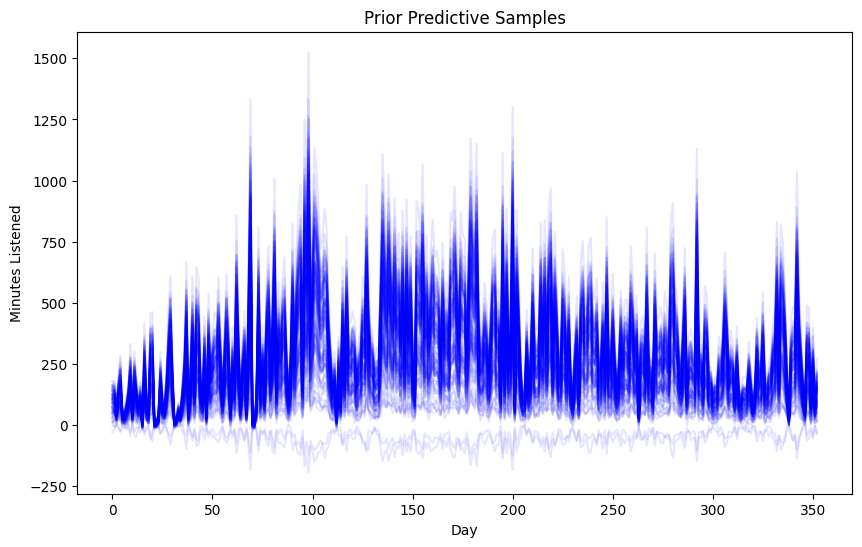

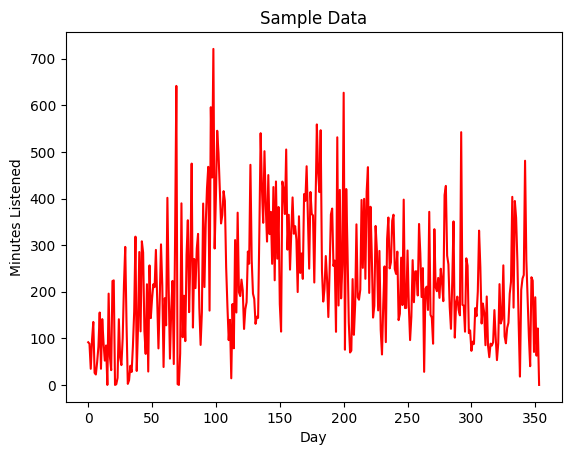

In [41]:
# letting 
y = spot['minutes_listened'].values

# Bayesian AR(1) model (code found in the PyMC3 documentation)
with pm.Model() as ar1_model:
    # Define the model
    phi = pm.Normal('phi', mu=1, sigma=.5)
    sigma = pm.HalfNormal('sigma', sigma=100)
    
    # Error term
    e_t = pm.Normal('e_t', mu=5, sigma=10, shape=len(y)-1)
    
    # AR(1) process
    y_pred = pm.Deterministic('y_pred', phi * y[:-1] + e_t)
    
    # Prior predictive sampling
    prior_pred = pm.sample_prior_predictive(samples=1000)

# printing prior predictive samples from the xarray dataset
moch = prior_pred.prior.y_pred.values

# extracting from y_pred variable so we can plot
moch1 = moch[0]

# Plotting the prior predictive samples
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(moch1[i], color='blue', alpha=0.1)
plt.xlabel('Day')
plt.ylabel('Minutes Listened')
plt.title('Prior Predictive Samples')
plt.show()

# plot sample data
plt.plot(y, color='red')
plt.xlabel('Day')
plt.ylabel('Minutes Listened')
plt.title('Sample Data')
plt.show()


Performing prior predictive tuning to make data reflect sample data more closely.

Main goal: eliminate neg values and reduce high values

Sampling: [e_t, phi, sigma]


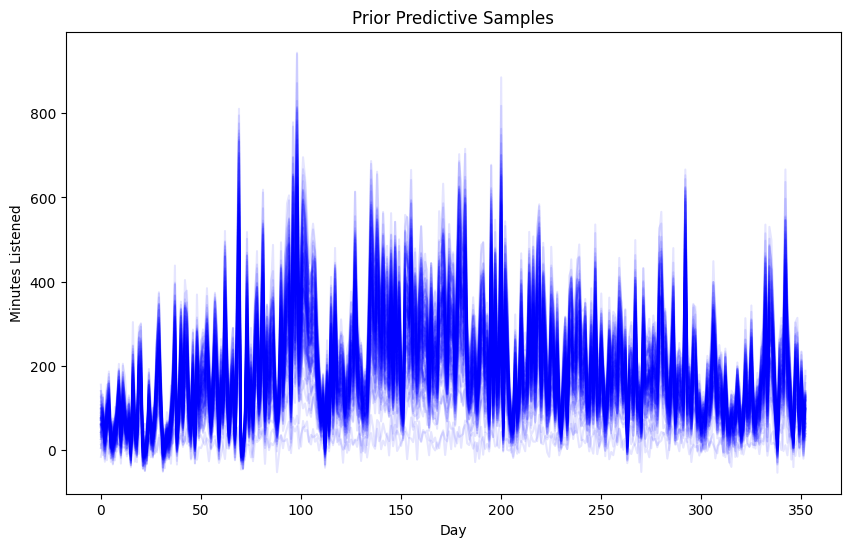

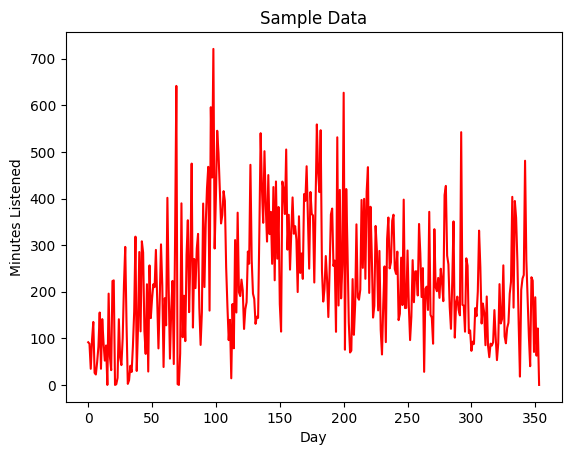

In [59]:
# Bayesian AR(1) model (code found in the PyMC3 documentation)
with pm.Model() as ar1_model:
    # Define the model
    phi = pm.Normal('phi', mu=.75, sigma=.25)
    sigma = pm.HalfNormal('sigma', sigma=.5)
    
    # Error term
    e_t = pm.Normal('e_t', mu=1, sigma=20, shape=len(y)-1)
    
    # AR(1) process
    y_pred = pm.Deterministic('y_pred', phi * y[:-1] + e_t)
    
    # Prior predictive sampling
    prior_pred = pm.sample_prior_predictive(samples=1000)

# printing prior predictive samples from the xarray dataset
moch = prior_pred.prior.y_pred.values

# extracting from y_pred variable so we can plot
moch1 = moch[0]

# Plotting the prior predictive samples
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(moch1[i], color='blue', alpha=0.1)
plt.xlabel('Day')
plt.ylabel('Minutes Listened')
plt.title('Prior Predictive Samples')
plt.show()

# plot sample data
plt.plot(y, color='red')
plt.xlabel('Day')
plt.ylabel('Minutes Listened')
plt.title('Sample Data')
plt.show()

After going through a few iterations of prior parameter selections through tuning, we ended up with these distribs. Now moving onto posterior.

    phi = Normal(mu=.75, sigma=.25)
    sigma = HalfNormal(sigma=.5)
    e_t = Normal(mu=1, sigma=20)

## Posterior Calculation

In [71]:
# Example data (assuming 'minutes_listened' from 'spot' DataFrame)
y = spot['minutes_listened'].values

# Bayesian AR(1) model with specified priors
with pm.Model() as ar1_model:
    # Priors
    phi = pm.Normal('phi', mu=0.75, sigma=0.25)  # Prior for autoregressive coefficient
    sigma = pm.HalfNormal('sigma', sigma=0.5)  # Prior for standard deviation of y_t
    e_t = pm.Normal('e_t', mu=1, sigma=20, shape=len(y)-1)  # Prior for error term
    
    # Error term (not explicitly modeled in PyMC3 but implied)
    # Expected value (mu) of y_t
    mu = phi * y[:-1] + e_t # Assuming y[:-1] is y_(t-1)
    
    # Likelihood (y_t is normally distributed around mu with standard deviation sigma)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y[1:])  # y[1:] is y_t

    # Sampling from MCMC
    trace = pm.sample(4000, tune=1000, cores=4)

TypeError: 'numpy.float64' object is not callable

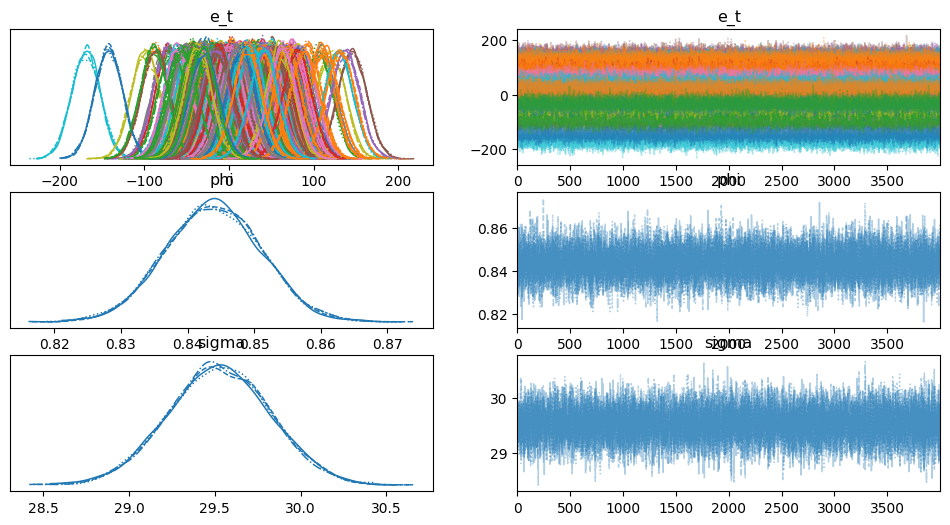

<Axes: xlabel='phi', ylabel='sigma'>

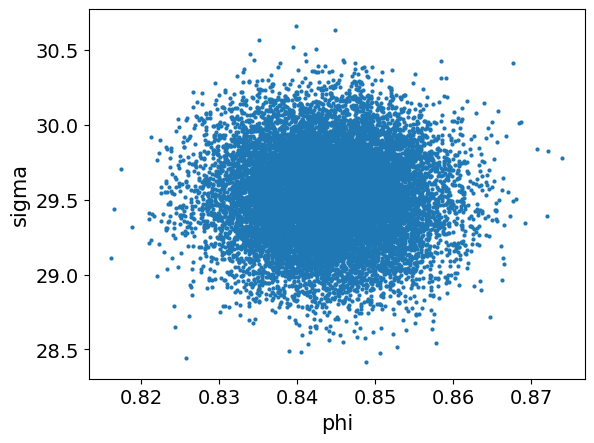

In [74]:
# Plot traceplot
az.plot_trace(trace)
plt.show()

# summary of posterior
az.summary(trace,hdi_prob=.95)

# correlation between phi and sigma
az.plot_pair(trace, var_names=['phi', 'sigma'])

- there are so many e_t's because we have a different e_t for each day in our data  

- no correlation between phi and sigma

- fuzzy caterpiller for all params, so looking good!

## Posterior Prediction and Interpretation

TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'